<a href="https://colab.research.google.com/github/MandilKarki/tessr/blob/main/clip_architecture.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install -U torch datasets transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.8/462.8 KB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 53.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 40.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 8.5 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [2]:
from datasets import load_dataset

imagenette = load_dataset(
    'frgfm/imagenette',
    'full_size',
    split='train',
    ignore_verifications=False  # set to True if seeing splits Error
)
imagenette

Generating train split:   0%|          | 0/9469 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3925 [00:00<?, ? examples/s]

Dataset imagenette downloaded and prepared to /root/.cache/huggingface/datasets/frgfm___imagenette/full_size/1.0.0/38929285b8abcae5c1305418e9d8fea5dd6b189bbbd22caba5f5537c7fa0f01f. Subsequent calls will reuse this data.


Dataset({
    features: ['image', 'label'],
    num_rows: 9469
})

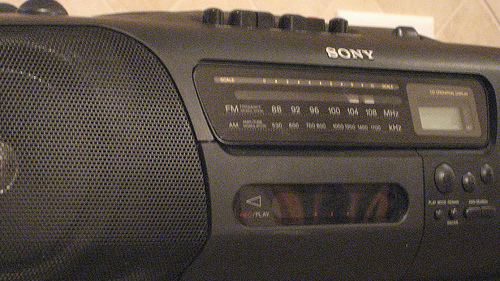

In [3]:
imagenette[0]['image']

In [4]:
from transformers import CLIPTokenizerFast, CLIPProcessor, CLIPModel
import torch

# if you have CUDA or MPS, set it to the active device like this
device = "cuda" if torch.cuda.is_available() else \
         ("mps" if torch.backends.mps.is_available() else "cpu")
model_id = "openai/clip-vit-base-patch32"

# we initialize a tokenizer, image processor, and the model itself
tokenizer = CLIPTokenizerFast.from_pretrained(model_id)
processor = CLIPProcessor.from_pretrained(model_id)
model = CLIPModel.from_pretrained(model_id).to(device)

In [5]:


prompt = "a dog in the snow"

# create transformer-readable tokens
inputs = tokenizer(prompt, return_tensors="pt")
inputs



{'input_ids': tensor([[49406,   320,  1929,   530,   518,  2583, 49407]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1]])}

In [6]:
# use CLIP to encode tokens into a meaningful embedding
text_emb = model.get_text_features(**inputs)
text_emb.shape

torch.Size([1, 512])

In [7]:
image = processor(
    text=None,
    images=imagenette[0]['image'],
    return_tensors='pt'
)['pixel_values'].to(device)
image.shape

torch.Size([1, 3, 224, 224])

<ipython-input-8-2695716cb526>:3: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3277.)
  plt.imshow(image.squeeze(0).T)


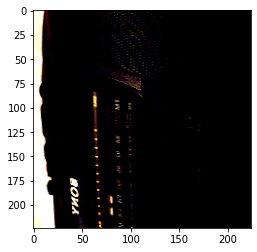

In [8]:
import matplotlib.pyplot as plt
# we can still visualize the processed image
plt.imshow(image.squeeze(0).T)

In [9]:


img_emb = model.get_image_features(image)
img_emb.shape



torch.Size([1, 512])

In [10]:
import numpy as np

np.random.seed(0)
# select 100 random image index values
sample_idx = np.random.randint(0, len(imagenette)+1, 100).tolist()
# extract the image sample from the dataset
images = [imagenette[i]['image'] for i in sample_idx]

In [11]:
from tqdm.auto import tqdm

batch_size = 16
image_arr = None

for i in tqdm(range(0, len(images), batch_size)):
    # select batch of images
    batch = images[i:i+batch_size]
    # process and resize
    batch = processor(
        text=None,
        images=batch,
        return_tensors='pt',
        padding=True
    )['pixel_values'].to(device)
    # get image embeddings
    batch_emb = model.get_image_features(pixel_values=batch)
    # convert to numpy array
    batch_emb = batch_emb.squeeze(0)
    batch_emb = batch_emb.cpu().detach().numpy()
    # add to larger array of all image embeddings
    if image_arr is None:
        image_arr = batch_emb
    else:
        image_arr = np.concatenate((image_arr, batch_emb), axis=0)
image_arr.shape

  0%|          | 0/7 [00:00<?, ?it/s]

(100, 512)

In [12]:
image_arr.min(), image_arr.max()

(-7.994915, 3.1525087)

In [13]:
image_arr = image_arr / np.linalg.norm(image_arr, axis=0)
image_arr.min(), image_arr.max()

(-0.4141056, 0.49008128)

In [14]:
text_emb = text_emb.cpu().detach().numpy()
scores = np.dot(text_emb, image_arr.T)
scores.shape

(1, 100)

In [15]:
top_k = 5
# get the top k indices for most similar vecs
idx = np.argsort(-scores[0])[:top_k]
idx

array([71, 24, 86, 76, 85])

71: 4.704943656921387


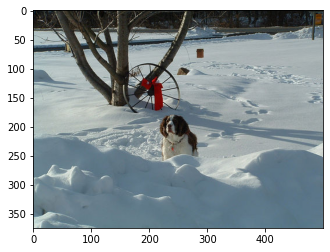

24: 3.666030168533325


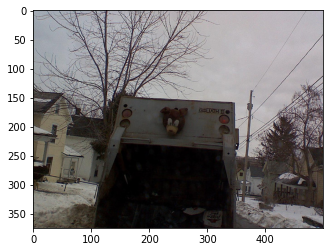

86: 3.1761646270751953


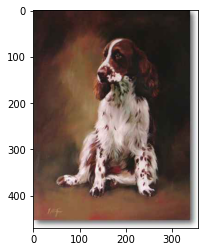

76: 3.1302287578582764


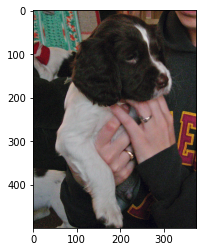

85: 2.8299427032470703


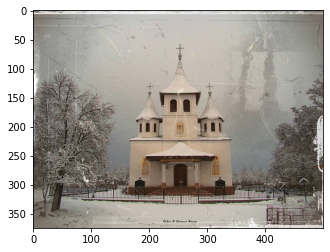

In [16]:
import matplotlib.pyplot as plt

# display the results
for i in idx:
    print(f"{i}: {scores[0][i]}")
    plt.imshow(images[i], cmap='gray')
    plt.show()

https://www.youtube.com/watch?v=989aKUVBfbk